In [1]:
import numpy as np
import scipy.special
from scipy.optimize import minimize

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, transpile, Aer, IBMQ, execute
from qiskit.circuit import Parameter
from qiskit.tools.jupyter import *
from qiskit.visualization import *
#from ibm_quantum_widgets import *
from qiskit.providers.aer import QasmSimulator

from src import QAOA_utilities as QAOAut
from src import CellFreeQAOA as CFQAOA

# Loading your IBM Quantum account(s)
#provider = IBMQ.load_account()

Initialize network parameters

In [2]:
M = 3 # number of cells
K = 3 # number of users
rho = 1 # max power
BW_max = 6 # max BW, M_hat in paper
rng = np.random.default_rng(2703)
#eta = np.random.rand(K) # power control fraction for each user
#alpha = np.random.rand(M,K)
#beta = np.random.rand(M,K)
eta = rng.random(K) # power control fraction for each user
alpha = rng.random((M,K))
beta = rng.random((M,K))

Discretize $t$ and create $X$ and its vectorized form

In [3]:
#tg = 10.0 ** np.array([-3.2, -3, -2.8, -2.6, -2.4, -2.2, -2., -1.8, -1.6, -1.4, -1.2, -1, -0.8, -0.6, -0.4, -0.2, 0, 1, 2, 3])
tg = 10.0 ** np.array([ -3, -2.5, -2.2, -1.8 , -1.5, -1, -0.5])
Nt = len(tg)
x_t = np.zeros(Nt)

X_mat = np.zeros((M,K))
x_vec = X_mat.flatten('F')
x = np.concatenate((x_vec,x_t))

Build auxiliary amtrices $A^{(k)}$, $B^{(k)}$, and $C = \sum_k A^{(k)} - B^{(k)}$

In [4]:
# Build auxiliary matrices
Pt = np.concatenate((np.zeros((Nt,M*K)),np.eye(Nt)), axis = 1)
Pk_list = []
for k in range(K):
    Pk = np.concatenate((np.zeros((M,M*k)), np.eye(M), np.zeros((M,M*(K-k-1)+Nt))), axis = 1 )
    Pk_list.append(Pk)
Pm_list = []
for m in range(M):
    Pm = np.zeros((K,M*K+Nt))
    for k in range(K):
        Pm[k,m+M*k] = 1
    Pk_list.append(Pm)
    
one_vec = np.ones(M*K+Nt)
one_vec_tilde = np.concatenate((np.ones(M*K),np.zeros(Nt)))

# build A and B

A_list = []
B_list = []

b_tilde_list = []
A_tilde_list = []

for k in range(K):
    A_tilde = np.zeros((M,M))
    b_tilde = np.zeros(M)

    for m in range(M):
        for n in range(M):
            A_tilde[m,n] = rho*eta[k]*alpha[m,k]*alpha[n,k]
        b_tilde[m] = alpha[m,k]*(rho*(np.sum(np.multiply(eta,beta[m,:])) - beta[m,k]*eta[k]) + 1)
    
    A_tilde_list.append(A_tilde)
    b_tilde_list.append(b_tilde)
    
    A_list.append( Pk_list[k].T@A_tilde@Pk_list[k] )
    B_list.append( np.outer((Pt.T @ tg),(b_tilde.T @ Pk_list[k])) )
    
C = np.sum( [ A_list[k] - B_list[k] for k in range(len(A_list)) ] , 0 )
EM = np.ones((M,M))
EMK = np.ones((M*K,M*K))
IK = np.eye(K)
D = np.kron(IK,EM)

c_bar = np.sum(C,0)
c_tilde = np.sum(C,1)
F = np.block( [[ C[0:(M*K),0:(M*K)]+D-EMK, np.zeros((M*K,Nt)) ], [ np.zeros((Nt,M*K)), np.eye(Nt) ]] )

In [5]:
# Hyperparams

p_param = 2
lambda_s = 60 

In [6]:
expectation = CFQAOA.get_expectation(M,K,BW_max,Nt, Pt, tg, C, c_bar, c_tilde, p_param, lambda_s)

theta = (2*p_param) * [0.5]

res = minimize(expectation, 
                      theta, 
                      method='COBYLA')
res

     fun: -54.05783430819808
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 45
  status: 1
 success: True
       x: array([-0.22914596,  0.65886763,  0.32306177,  0.25204352])

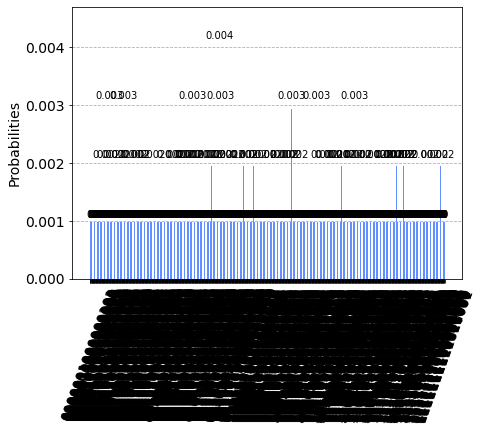

In [7]:
backend = Aer.get_backend('aer_simulator')
backend.shots = 1024

qc_res = CFQAOA.create_qaoa_circ(M,K,BW_max,Nt, tg, C, c_bar, c_tilde, res.x, lambda_s)
qc_res = transpile(qc_res, backend)
counts = backend.run(qc_res, seed_simulator=2703).result().get_counts()

plot_histogram(counts)

Now check among the best solutions which is the better

In [13]:
x_best = max(counts, key=counts.get)
v_best = counts[x_best]
xbest_list = []
[xbest_list.append(k) for k,v in counts.items() if float(v) >= 0.75*v_best]
print('Identified ',len(xbest_list),' combinations within 75% of best value:\n')
print(xbest_list)
print('Value of their objective function is:\n')
print([-CFQAOA.problem_objective(x_best,tg,Pt, C, lambda_s) for x_best in xbest_list])

xv_best_list = []
for x in xbest_list:
    xv = np.zeros(len(x))
    for i in range(len(x)):
        if x[i] == '1':
            xv[i] = 1
    xv_best_list.append(xv)
    
    
print('\nObjective value without soft-constrain penalty:\n')
print([tg.T @ (Pt @ xv_best) for xv_best in xv_best_list])

print('Soft-constraint value:\n')
for k in range(K):
    A = A_list[k]
    B = B_list[k]
    print('for k = ',k)
    print([ xv_best.T @ ((A-B) @ xv_best) for xv_best in xv_best_list])


Identified  8  combinations within 75% of best value:

['0110011010001100', '1010110010011110', '1100011110011100', '0001110010011100', '0001010010000110', '0110011001000110', '0100111110111100', '1001110010001110']
Value of their objective function is:

[90.60312518400723, 63.324408101778594, 41.88617938082108, 71.69757409228676, 58.29621029103015, 72.99546781704427, 14.107680625460395, 59.03672446892474]

Objective value without soft-constrain penalty:

[0.047471708526294926, 0.15378128197109686, 0.053781281971096856, 0.053781281971096856, 0.1316227766016838, 0.1326227766016838, 0.05694355963126524, 0.14747170852629493]
Soft-constraint value:

for k =  0
[1.4049107813939385, 1.0379325452850072, 0.6260610313154291, 0.0, 0.0, 1.2519639539779868, 0.16804692641666685, 0.04870124855041328]
for k =  1
[0.16076683736091585, 0.06244798224302567, 0.15478432909527026, 1.210662232366549, 1.0100912009104046, 0.080029688796738, 0.1547407929010445, 0.978371005962583]
for k =  2
[-0.056416727496838

In [9]:
xbest_list_sorted = CFQAOA.best_n_SINR(xbest_list, M, K, eta, alpha, beta, rho)
[print('Optimal string: ', elem) for elem in xbest_list_sorted] 
[print('Optimal SINR: ', CFQAOA.SINR_from_bitstring(elem, M, K, eta, alpha, beta, rho)) for elem in xbest_list_sorted] 

Optimal string:  1100011110011100
Optimal string:  0100111110111100
Optimal string:  0110011010001100
Optimal string:  0110011001000110
Optimal string:  1010110010011110
Optimal string:  1001110010001110
Optimal string:  0001110010011100
Optimal string:  0001010010000110
Optimal SINR:  [0.49278761 0.21702771 0.00056466]
Optimal SINR:  [0.26816916 0.21930448 0.00056466]
Optimal SINR:  [8.29636698e-01 2.17027708e-01 3.74040121e-04]
Optimal SINR:  [8.29636698e-01 2.17027708e-01 2.48779699e-04]
Optimal SINR:  [7.90117116e-01 2.19304483e-01 1.28283662e-04]
Optimal SINR:  [2.24713205e-01 5.42079797e-01 1.28283662e-04]
Optimal SINR:  [0.00000000e+00 5.42079797e-01 1.28283662e-04]
Optimal SINR:  [0.00000000e+00 5.39831885e-01 1.28283662e-04]


/home/alb/Scrivania/Quantum/Projects/Applications/QAOA-CellFreeMIMO/src/CellFreeQAOA.py:126: RuntimeWarning: invalid value encountered in double_scalars
  snr[k] = num/den


[None, None, None, None, None, None, None, None]

Solve problem by brute force

In [10]:
CFQAOA.bruteforce_SINR(M, K, BW_max, eta, alpha, beta, rho)

Actual full search best

ID:  79
MIN SINR:  0.000564663102721927
Best X:  [[0. 0. 1.]
 [0. 0. 1.]
 [1. 1. 1.]]


array([[0., 0., 1.],
       [0., 0., 1.],
       [1., 1., 1.]])